# Pectoral Muscle Removal from Mammograms

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab

### Ensuring same orientation of all images
In order for the algorithm to generalize over all mammograms, we first right-orient all images. To detect left-oriented breast images, we simply compare the number of nonzero pixels on both half of the images.

This is quite a rudimentary way to detect orientation, and works because the the background pixels are completely black and thus gives us an idea of the location of breast on either half of the image

In [2]:
from skimage import io
from skimage import color
import cv2

def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

def read_image(filename):
    image = io.imread(filename)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image



### Applying canny edge detection

In [3]:
from skimage.feature import canny
from skimage.filters import sobel

def apply_canny(image):
    canny_img = canny(image, 6)
    return sobel(canny_img)

In [4]:
from skimage.transform import hough_line, hough_line_peaks

def get_hough_lines(canny_img):
    h, theta, d = hough_line(canny_img)
    lines = list()
    print('\nAll hough lines')
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        print("Angle: {:.2f}, Dist: {:.2f}".format(np.degrees(angle), dist))
        x1 = 0
        y1 = (dist - x1 * np.cos(angle)) / np.sin(angle)
        x2 = canny_img.shape[1]
        y2 = (dist - x2 * np.cos(angle)) / np.sin(angle)
        lines.append({
            'dist': dist,
            'angle': np.degrees(angle),
            'point1': [x1, y1],
            'point2': [x2, y2]
        })
    
    return lines

In [5]:
def shortlist_lines(lines):
    MIN_ANGLE = 10
    MAX_ANGLE = 70
    MIN_DIST  = 5
    MAX_DIST  = 200
    
    shortlisted_lines = [x for x in lines if 
                          (x['dist']>=MIN_DIST) &
                          (x['dist']<=MAX_DIST) &
                          (x['angle']>=MIN_ANGLE) &
                          (x['angle']<=MAX_ANGLE)
                        ]
    print('\nShorlisted lines')
    for i in shortlisted_lines:
        print("Angle: {:.2f}, Dist: {:.2f}".format(i['angle'], i['dist']))
        
    return shortlisted_lines

In [6]:
from skimage.draw import polygon

def remove_pectoral(shortlisted_lines):
    shortlisted_lines.sort(key = lambda x: x['dist'])
    pectoral_line = shortlisted_lines[0]
    d = pectoral_line['dist']
    theta = np.radians(pectoral_line['angle'])
    
    x_intercept = d/np.cos(theta)
    y_intercept = d/np.sin(theta)
    
    return polygon([0, 0, y_intercept], [0, x_intercept, 0])

In [7]:
def display_image(filename):
    image = read_image(filename)
    canny_image = apply_canny(image)
    lines = get_hough_lines(canny_image)
    shortlisted_lines = shortlist_lines(lines)
    
    fig, axes = plt.subplots(1, 4, figsize=(15,10))
    fig.tight_layout(pad=3.0)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0])
    
    
    axes[0].set_title('Right-oriented mammogram')
    axes[0].imshow(image, cmap=pylab.cm.gray)
    axes[0].axis('on') 
    
    axes[1].set_title('Hough Lines on Canny Edge Image')
    axes[1].imshow(canny_image, cmap=pylab.cm.gray)
    axes[1].axis('on')
    axes[1].set_xlim(0,image.shape[1])
    axes[1].set_ylim(image.shape[0])
    for line in lines:
        axes[1].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    axes[2].set_title('Shortlisted Lines')
    axes[2].imshow(canny_image, cmap=pylab.cm.gray)
    axes[2].axis('on')
    axes[2].set_xlim(0,image.shape[1])
    axes[2].set_ylim(image.shape[0])
    for line in shortlisted_lines:
        axes[2].plot((line['point1'][0],line['point2'][0]), (line['point1'][1],line['point2'][1]), '-r')
        
    rr, cc = remove_pectoral(shortlisted_lines)
    image[rr, cc] = 0
    axes[3].set_title('Pectoral muscle removed')
    axes[3].imshow(image, cmap=pylab.cm.gray)
    axes[3].axis('on') 
    
    plt.show()    

/home/gsunit/my-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  app.launch_new_instance()



All hough lines
Angle: 90.00, Dist: 2.50
Angle: -27.65, Dist: 112.64
Angle: 14.58, Dist: 51.57
Angle: 28.66, Dist: 234.80
Angle: 78.94, Dist: 328.92
Angle: 56.82, Dist: 306.89

Shorlisted lines
Angle: 14.58, Dist: 51.57


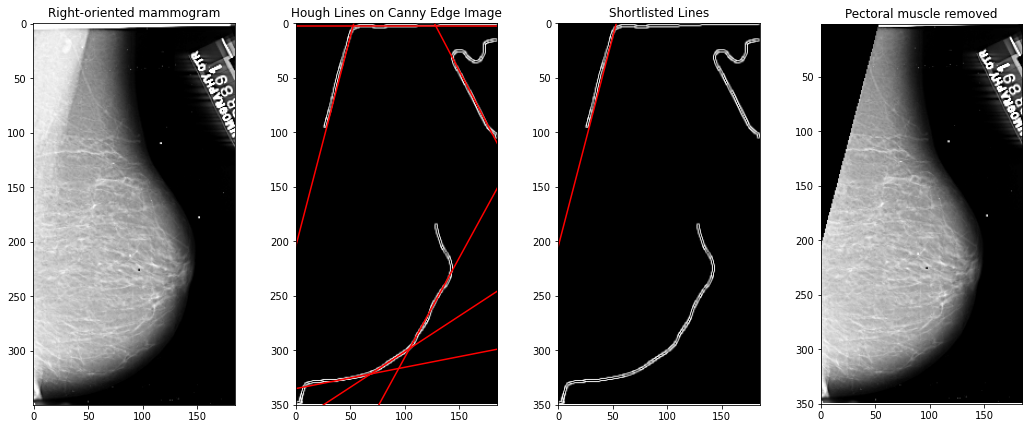

In [8]:
display_image('mammo_1.png')

/home/gsunit/my-env/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  app.launch_new_instance()



All hough lines
Angle: -22.63, Dist: 33.54
Angle: 30.67, Dist: 114.64
Angle: -2.51, Dist: -8.51
Angle: 82.96, Dist: 305.89
Angle: 26.65, Dist: 231.79
Angle: 1.51, Dist: 13.52
Angle: 30.67, Dist: 243.81
Angle: 90.00, Dist: 2.50
Angle: -8.55, Dist: 90.61

Shorlisted lines
Angle: 30.67, Dist: 114.64


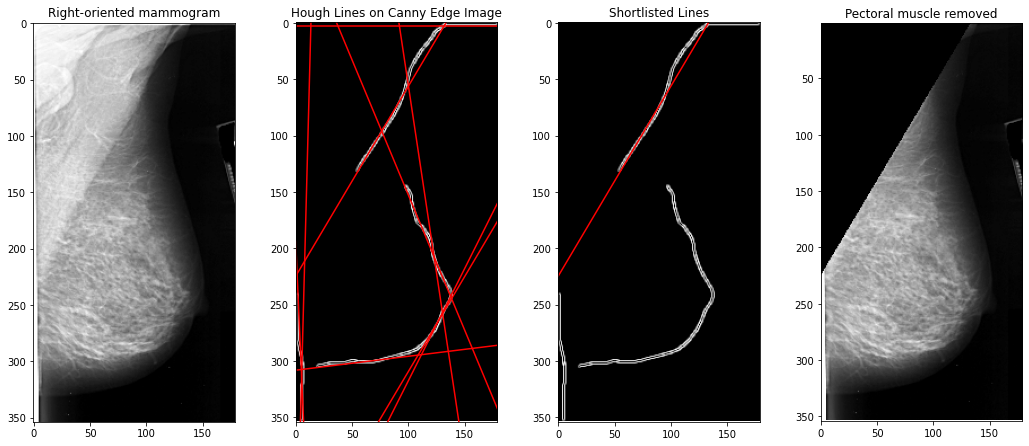

In [9]:
display_image('mammo_2.png')


All hough lines
Angle: 90.00, Dist: 2.50
Angle: 17.60, Dist: 47.56
Angle: 49.78, Dist: 240.81
Angle: 40.73, Dist: 218.78
Angle: 33.69, Dist: 196.75
Angle: -7.54, Dist: 55.57
Angle: -20.61, Dist: 14.52
Angle: -3.52, Dist: 69.59
Angle: -11.56, Dist: 39.55

Shorlisted lines
Angle: 17.60, Dist: 47.56
Angle: 33.69, Dist: 196.75


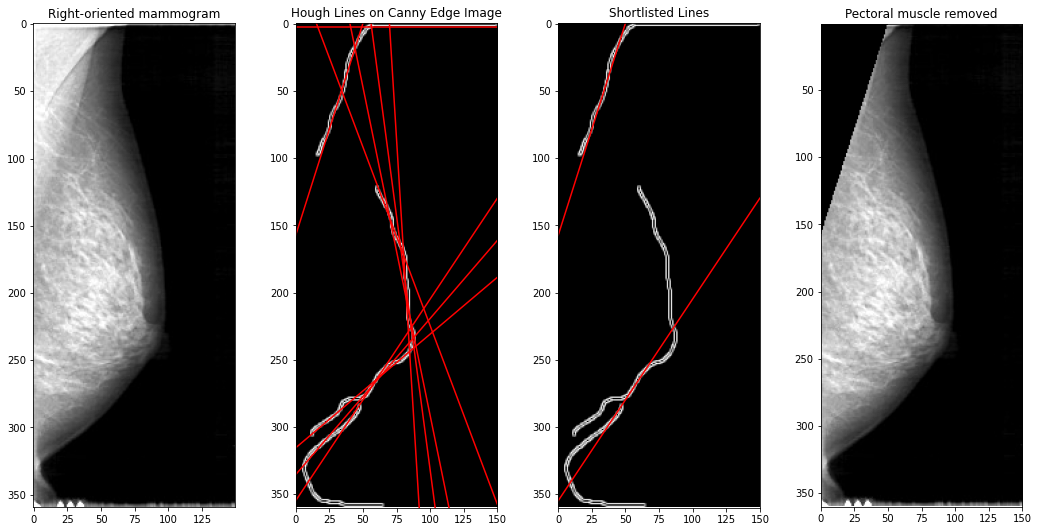

In [10]:
display_image('mammo_3.jpg')


All hough lines
Angle: 25.64, Dist: 78.60

Shorlisted lines
Angle: 25.64, Dist: 78.60


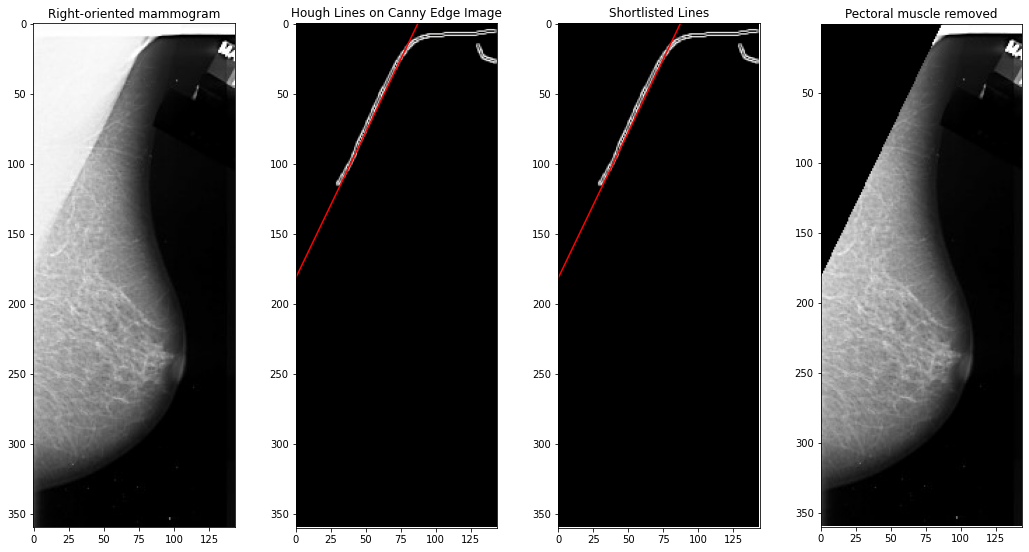

In [11]:
display_image('mammo_4.jpg')


All hough lines
Angle: 0.50, Dist: 5.51
Angle: 23.63, Dist: 61.58
Angle: -44.75, Dist: -13.52

Shorlisted lines
Angle: 23.63, Dist: 61.58


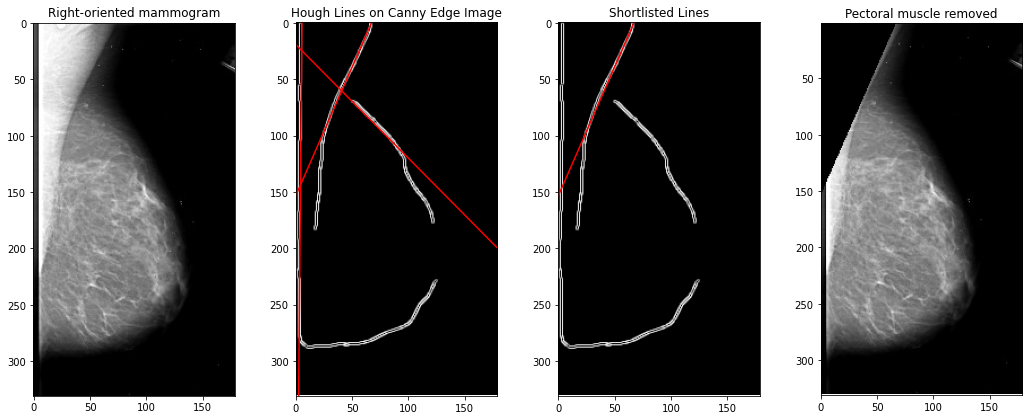

In [12]:
display_image('mammo_5.jpg')